####**nama : Wira triono**

####**kota : Pematangsiantar(Sumatra utara)**
---
# **Prediksi Nama Buah**
---
> project submission saya yaitu memprediksi nama 4 macam buah yaitu **apel, jeruk, mangga dan pisang**. total jumlah datasets ada **>10000 sample** yg dari 4 kategori itu **masing-masing memiliki >2500 sample**. **Resolusi gambar** yang ada di dataset saya **beragam** karna saya mendapatkannya dari sumber yang berbeda beda. Data diupload ke Gdrive dalam bentik **zip file**
---
sumber gambar:
*   https://www.kaggle.com/datasets (kaggle)
*   https://storage.googleapis.com/openimages/web/index.html (Open Images V6)
*   https://www.bing.com/images (bing)







#download dan extract dataset

In [1]:
! gdown 1rf7DPzh58X234HVI5lXU4TrLBu7d-8p-

Downloading...
From: https://drive.google.com/uc?id=1rf7DPzh58X234HVI5lXU4TrLBu7d-8p-
To: /content/ImgDataset.zip
100% 586M/586M [00:02<00:00, 222MB/s]


In [2]:
# unzip file
! unzip -q ImgDataset.zip

# install splitfolder
!pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
# import modul
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
import tensorflow as tf
import matplotlib.pyplot as plt
import splitfolders
import pathlib
import os

#menampilkan gambar 

Found 10050 files belonging to 4 classes.


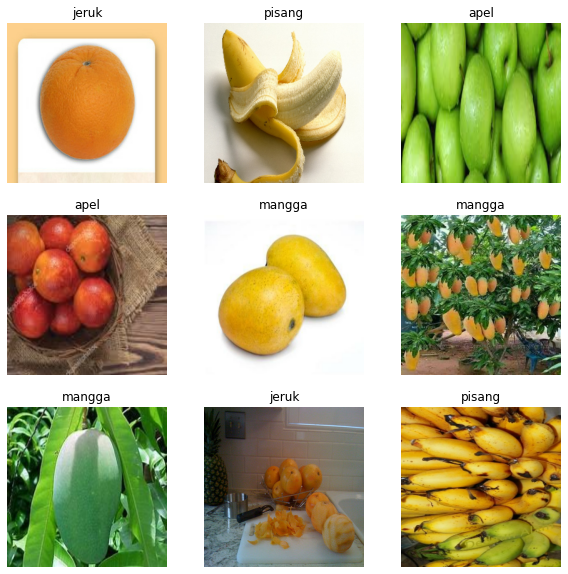

In [5]:
images = image_dataset_from_directory("/content/ImgDataset/gambar",
                                      shuffle=True)

nama_label = images.class_names

plt.figure(figsize=(10,10))
for img, label in images.take(1):
  for i in range(9):
    ax = plt.subplot(3,3,i+1)
    plt.imshow(img[i].numpy().astype("uint8"))
    plt.title(nama_label[label[i]])
    plt.axis('off')

#split data menjadi train(80%) dan tes(20%)

In [6]:
path_img = "/content/ImgDataset/gambar"
path_output = "/content/ImgDataset"

splitfolders.ratio(path_img, path_output, seed=1337, ratio=(0.8,0.2), group_prefix=None)

train_dir = os.path.join(path_output,"train")
val_dir = os.path.join(path_output,"val")

Copying files: 10050 files [00:02, 4415.61 files/s]


#Augmentasi data

In [18]:
img_shape = (224,224)

# train
train_gen = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=30,
                    horizontal_flip=True,
                    shear_range = 0.2,
                    zoom_range = 0.1,
                    fill_mode = 'nearest')

train = train_gen.flow_from_directory(
                    train_dir,
                    batch_size=128,
                    target_size= img_shape,
                    class_mode = "categorical")
 

# test
test_gen = ImageDataGenerator(
                    rescale=1./255)

test = test_gen.flow_from_directory(
                    val_dir,
                    batch_size=128,
                    target_size= img_shape,
                    class_mode = "categorical")

Found 8040 images belonging to 4 classes.
Found 2010 images belonging to 4 classes.


#Transfer learning MobileNet

In [15]:
mobileNetv2 = MobileNetV2(input_shape=(img_shape+(3,)),
                        weights="imagenet",
                        include_top=False)

mobileNetv2.trainable = False

9420800/9406464 [==============================] - 0s 0us/step


#Modelling

In [19]:
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras import Sequential, optimizers, losses, callbacks, regularizers

class myCallback(callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if((logs.get('accuracy') - logs.get('val_accuracy')) > 0.01):
      print("\n Stop training")
      self.model.stop_training = True

callbacks = myCallback()

model = Sequential([
    mobileNetv2,
    Flatten(),
    Dropout(0.2),
    Dense(64, activation='swish', kernel_regularizer= regularizers.L1(0.001)),
    Dropout(0.2),
    Dense(64, activation='swish', kernel_regularizer= regularizers.L1(0.001)),
    Dense(4, activation='softmax')
])


model.compile(optimizer=optimizers.Adam(learning_rate=1e-4),
              loss=losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 flatten_1 (Flatten)         (None, 62720)             0         
                                                                 
 dropout_3 (Dropout)         (None, 62720)             0         
                                                                 
 dense_4 (Dense)             (None, 64)                4014144   
                                                                 
 dropout_4 (Dropout)         (None, 64)                0         
                                                                 
 dense_5 (Dense)             (None, 64)                4160      
                                                      

In [20]:
hist = model.fit(train,
          epochs=10,
          steps_per_epoch=32,
          callbacks=callbacks,
          validation_data=test,
          validation_steps=10,
          verbose=1)

Epoch 1/10
32/32 [==============================] - 85s 3s/step - loss: 18.7299 - accuracy: 0.7836 - val_loss: 16.1731 - val_accuracy: 0.9172
Epoch 2/10
32/32 [==============================] - 88s 3s/step - loss: 14.1930 - accuracy: 0.9121 - val_loss: 12.1475 - val_accuracy: 0.9227
Epoch 3/10
32/32 [==============================] - 87s 3s/step - loss: 10.5540 - accuracy: 0.9268 - val_loss: 9.0240 - val_accuracy: 0.9359
Epoch 4/10
32/32 [==============================] - 78s 2s/step - loss: 7.9194 - accuracy: 0.9462 - val_loss: 6.9087 - val_accuracy: 0.9391
Epoch 5/10
32/32 [==============================] - 77s 2s/step - loss: 6.1333 - accuracy: 0.9423 - val_loss: 5.4078 - val_accuracy: 0.9484
Epoch 6/10
32/32 [==============================] - 79s 2s/step - loss: 4.8242 - accuracy: 0.9573 - val_loss: 4.3171 - val_accuracy: 0.9531
Epoch 7/10
32/32 [==============================] - 78s 2s/step - loss: 3.9011 - accuracy: 0.9597 - val_loss: 3.5278 - val_accuracy: 0.9609
Epoch 8/10
32/3

#Plot akurasi dan loss

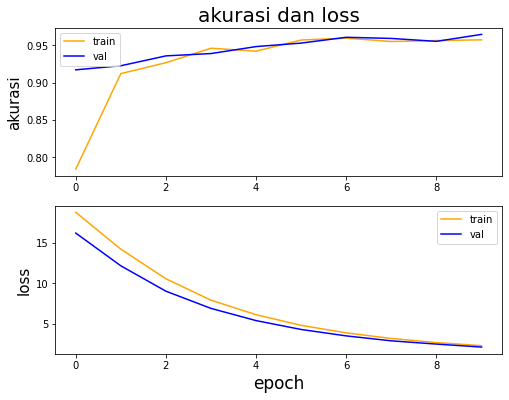

In [21]:
acc= hist.history['accuracy']
val= hist.history['val_accuracy']
loss= hist.history["loss"]
valloss= hist.history["val_loss"]

fig,ax = plt.subplots(2,1,figsize=(8,6))
ax[0].plot(acc,'orange',label="train")
ax[0].plot(val,"blue",label="val")
ax[0].set_title("akurasi dan loss",fontsize=20)
ax[0].set_ylabel("akurasi",fontsize=15)
ax[0].legend()

ax[1].plot(loss,'orange',label="train")
ax[1].plot(valloss,"blue",label="val")
ax[1].set_ylabel("loss",fontsize=15)
ax[1].set_xlabel("epoch",fontsize=17)
ax[1].legend()
plt.show()

#save model dan convert ke tflite

In [22]:
export_dir = '/content/ImgDataset'
tf.saved_model.save(model, export_dir)

In [23]:
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
tflite_model = converter.convert()

In [24]:
tflite_model_file = pathlib.Path('vegs.tflite')
tflite_model_file.write_bytes(tflite_model)

24945064